In [46]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import random
%matplotlib inline

device = 'mps' if torch.backends.mps.is_available() else \
  'cuda' if torch.backends.cuda.is_available() else \
  'cpu'

device = 'cpu'
print(f'Device: {device}')
print(f'Torch version: {torch.__version__}')
random.seed(0)
datafolder = './data/FMNIST'

fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)

tr_images = fmnist.data.to(device)
tr_targets = fmnist.targets.to(device)

Device: mps
Torch version: 1.13.0.dev20221002


In [47]:
class FMINSTDataset(Dataset):
    def __init__(self, x, y):
        #x = (x.float() -128) / 255
        x = x.float() / 255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
        
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)
    
def get_data():
    train = FMINSTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
        ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [48]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [49]:
model, loss_fn, optimizer = get_model()
trn_dl = get_data()
losses, accuracies = [], []

for epoch in range(5):
    print(f'\nEpoch: {epoch}', end='')
    epoch_losses, epoch_accuracies = [], []
    print('\n\tTraining cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        #print(f'\tTraing cicle: ix  = {ix}')
        #print(f'\tTraing cicle: x   = {x}')
        #print(f'\tTraing cicle: y   = {y}')
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
        #if ix>100: break
    
    epoch_loss = np.array(epoch_losses).mean()
        
    print('\n\tAccuracy cicle: ', end='')
    for ix, batch in enumerate(iter(trn_dl)):
        print('.', end='') if ix%33 == 0 else ""
        x, y = batch
        #print(f'\tAccuracy cicle: ix    = {ix}')
        #print(f'\tAccuracy cicle: batch = {batch}')
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
        #if ix>100: break
            
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)


Epoch: 0
	Training cicle: .....................................

KeyboardInterrupt: 

In [40]:
import platform
print(f'Platform : {platform.platform()}')
print(f'Device   : {device}')
print(f'Torch MPS: {torch.has_mps}')
print(losses)
print(accuracies)

#[0.8396197241942088, 0.5353731442213059, 0.48255981571276985, 0.45433049147129057, 0.4355701746821404]
#[0.7962333333333333, 0.8300333333333333, 0.8386, 0.8508166666666667, 0.8534833333333334]
model, loss_fn, optimizer = get_model()
trn_dl = get_data()
x, y = next(iter(trn_dl))
%timeit train_batch(x, y, model, optimizer, loss_fn)

Platform : macOS-12.6-arm64-arm-64bit
Device   : cpu
Torch MPS: True
[0.8485401981830597, 0.5382654979626338, 0.4834044220368067, 0.45544177660942076, 0.43613685299952826]
[0.8089833333333334, 0.8280166666666666, 0.8409, 0.8503166666666667, 0.8556]
1.25 ms ± 3.42 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
tt = torch.rand(3,4)
print(tt);

print(tt.max(1))
print(tt.max(-1))


tensor([[0.2419, 0.7571, 0.8596, 0.1669],
        [0.4263, 0.3741, 0.9394, 0.9966],
        [0.9433, 0.7771, 0.7811, 0.4204]])
torch.return_types.max(
values=tensor([0.8596, 0.9966, 0.9433]),
indices=tensor([2, 3, 0]))
torch.return_types.max(
values=tensor([0.8596, 0.9966, 0.9433]),
indices=tensor([2, 3, 0]))


/var/folders/44/sqmxmlfx5k383gls301l5s100000gn/T/ipykernel_79989/3339653493.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks().tolist()])


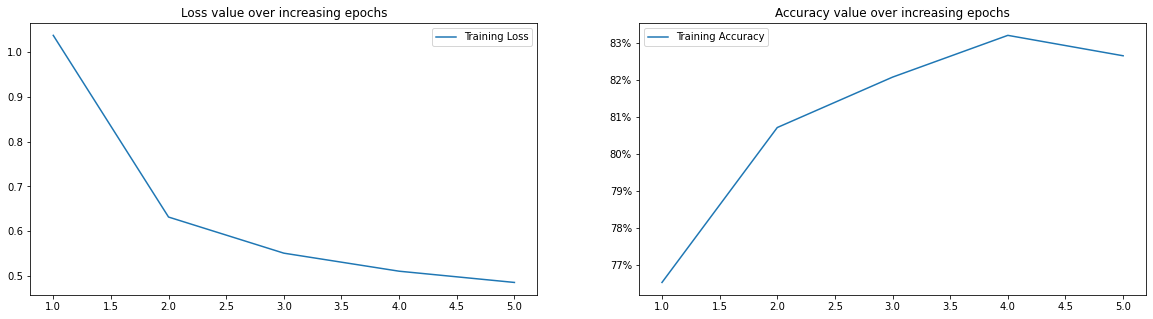

In [35]:
epochs = np.arange(5) + 1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks().tolist()])
plt.legend()